In [19]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA
from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel, NonHermitianHamiltonianOBC

import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

In [20]:
class SSH1DOBC(NonHermitianHamiltonianOBC):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref=E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 2

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t1'], kwargs['t2'], kwargs['gamma']

    def get_kpoints(self):
        n_points = 5
        kpoints = [[k] for k in np.linspace(0, np.pi, n_points)]
        return kpoints

    def initiate(self):
        # different parameter region for the different gap type
        t1 = 3*np.random.random()
        t2 = 1.
        gamma = 3*np.random.random()

        self.parameters = t1, t2, gamma

    def is_real_line_gap(self):
        # kappa, g1, g2 = self.parameters
        # if not ((t1 >= t2 + gamma/2) 
        #         or (t1 <= -t2 - gamma/2) 
        #         or ((t1 >= t2 - gamma/2) and (t1 <= -t2 + gamma/2)) 
        #         or ((t1 <= t2 - gamma/2) and (t1 >= -t2 + gamma/2))):
        #     return False
        for k in self.get_kpoints():
            hk = self.get_Hamiltonian(k)
            Es = LA.eigvals(hk)
            #print(np.abs(np.real(Es)))
            if np.any(np.abs(np.real(Es - self.E_ref)) < 1e-3):
                return False
        return True    
    
    def is_imaginary_line_gap(self):
        return not self.is_real_line_gap()
    
    def get_Hamiltonian(self, k):
        k = k[0]

        #hk = np.zeros((2,2), dtype=complex)
        t1, t2, gamma = self.parameters

        g = np.sqrt(np.abs((t1-gamma/2)/(t1+gamma/2)))
        beta = g*np.exp(1j*k)

        hk = np.array([
            [0,  t1 + gamma/2 + t2/beta],
            [t1 - gamma/2 + t2*beta, 0]
        ])
        hk = hk - self.E_ref*sigma_0

        # if gap_type == 'point':
        #     hk = hk - E_ref*sigma_0
        #     hkc = np.transpose(np.conjugate(hk))
        #     hk = np.block([[np.zeros(hk.shape), hk], [hkc, np.zeros(hk.shape)]])

        return hk
    
class SSH1DOBCPerturbation(NonHermitianHamiltonianOBC):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 2

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t1'], kwargs['t2'], kwargs['m1'], kwargs['m2']

    def get_kpoints(self):
        n_points = 5
        kpoints = [[k] for k in np.linspace(0,np.pi,n_points)]
        return kpoints

    def initiate(self):
        # different parameter region for the different gap type
        t1 = -1+2*np.random.random()
        t2 = -1+2*np.random.random()
        m1 = -1+2*np.random.random()
        m2 = -1+2*np.random.random()
        self.parameters = t1, t2, m1, m2
    
    def get_Hamiltonian(self, k):
        k = k[0]
        t1, t2, m1, m2 = self.parameters
        
        hk = m1*sigma_x + m2*sigma_y
        hk = hk + (t1+t2*np.cos(k))*sigma_x + t2*np.sin(k)*sigma_y
        hk = hk*0.1

        return hk

In [21]:
gap_type="real line"
E_ref = 0.
hamiltonian_model = SSH1DOBC(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 200
_models, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

cluster = Cluster(similarity_function=topology_comparator, verbose=False)
center_indices, group_number = cluster.fit(models)
print(center_indices)
print(group_number)
print("The number of centers: ", len(center_indices))

Number of samples:  182


/home/longyang/OSC/ml_topological_classification_non_-hermitian/cases_OBC/../topology_model/topology_comparator_utils.py:26: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a0)/epsilon
/home/longyang/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/longyang/OSC/ml_topological_classification_non_-hermitian/cases_OBC/../topology_model/topology_comparator_utils.py:34: RuntimeWarning: divide by zero encountered in log10
  if np.log10(np.abs(v)) < c_val:


[0 5]
[117  65]
The number of centers:  2


In [22]:
for model in [models[index] for index in center_indices]:
    print(model.get_parameters())

(2.7990776848699372, 1.0, 2.815646494576399)
(1.3229581824266679, 1.0, 2.945348744419909)


In [23]:
print("The group number before introducing perturbations: ", group_number)

center_models = [models[i] for i in center_indices]


print(center_indices)

print("parameters:")
for model in center_models:
    print(model.get_parameters())

E_ref = 0.
print("Gap type: ", gap_type)
hamiltonian_perturbation = SSH1DOBCPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

n_center = len(center_models)
similarity_center = np.zeros((n_center, n_center))
for i in range(n_center):
    for j in range(i, n_center):
        similarity_center[i,j] = topology_verifier(center_models[i], center_models[j], perturbations)
        similarity_center[j,i] = similarity_center[i,j]

print("Similarity matrix for the centers: ")
print(similarity_center)

print()
print("The new group number: ")

new_center_indices = list()
new_group_number  = list()

# Add the first element to the group
new_center_indices.append(0)
new_group_number.append(group_number[0])

# cluster
for i in range(1, n_center):
    flag = True
    for i_center_index in new_center_indices:
        if similarity_center[i_center_index, i] > 0.5:
            # topologically same
            new_group_number[i_center_index] += group_number[i]
            flag = False
            break
            
    # topologically different
    if flag:
        new_center_indices.append(i)
        new_group_number.append(group_number[i])
                    
new_center_indices = [center_indices[i] for i in new_center_indices]
print(new_center_indices)
print(new_group_number)
print("The number of phases: ", len(new_group_number))

# hamiltonian_perturbation = SSH1DPerturbation(E_ref=E_ref)
# generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

# n_sample = 100
# perturbations, vs = generator.generate_models(n_sample)
# new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations)
# print("The number of phases: ", len(new_group_number))

The group number before introducing perturbations:  [117  65]
[0 5]
parameters:
(2.7990776848699372, 1.0, 2.815646494576399)
(1.3229581824266679, 1.0, 2.945348744419909)
Gap type:  real line
Similarity matrix for the centers: 
[[1. 0.]
 [0. 1.]]

The new group number: 
[0, 5]
[117, 65]
The number of phases:  2


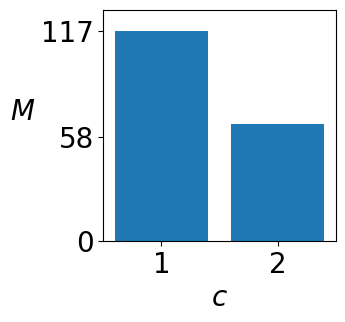

In [24]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

In [25]:
classifier = Classifier(similarity_func=topology_comparator, cluster_centers=[models[index] for index in new_center_indices])
n1 = 51
n2 = 51
t1s = np.linspace(0.001,3,n1)
gammas = np.linspace(0.001,3,n2)
v_list = np.zeros((n1, n2))


for i in range(n1):
    for j in range(n2):
        hamiltonian = SSH1DOBC(E_ref=E_ref)
        hamiltonian.set_parameters(t1=t1s[i], t2=1., gamma=gammas[j])
        #print(hamiltonian.get_parameters())
        if hamiltonian.is_real_line_gap():
            _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type="real line")
            #v_list.append(1)
            v_list[i,j] = classifier.classify(_model)

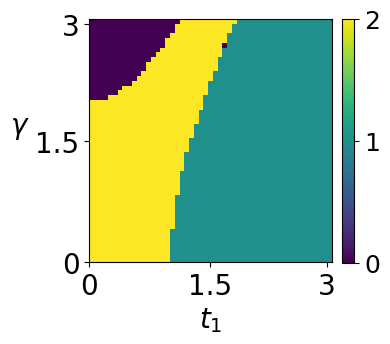

In [26]:
plt.figure(figsize=(4,4))
plt.imshow(np.transpose(v_list), origin='lower',extent = [0,n1,0,n2])
plt.xlabel(r"$t_1$",fontsize=20)
plt.ylabel(r"$\gamma$",fontsize=20,rotation=0,horizontalalignment='right')
plt.xticks([0, n1/2, n1-1],[r"0", "1.5", r"3"],fontsize=20)
plt.yticks([0, n2/2, n2-1],[r"0", "1.5", r"3"], fontsize=20)

cb = plt.colorbar(ticks=range(len(center_indices)+1), fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

In [27]:
from tools import save_data, save_data_M

name = "1D_SSH_OBC_real"
save_data(new_center_indices, new_group_number, "fig2_{0}_group_number.h5".format(name))
save_data_M(v_list, "fig2_{0}_phase_diagram.h5".format(name))
print(name)

1D_SSH_OBC_real


In [16]:
# _Q1 = Qs[0][0]
# _Q2 = Qs[53][0]

# n_a = 51
# a_list = np.linspace(0, 1, n_a)
# vals = np.zeros((n_a, len(_Q1)))
# for ia, a in enumerate(a_list):
#     _Q = (1-a)*_Q1 + a*_Q2
#     _val = np.linalg.eigvals(_Q)
#     vals[ia] = np.real(_val)

# for i in range(len(_Q1)):
#     plt.scatter(a_list, vals[:,i])